In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna

# Paths
base_path = '../Competition_data'
dataset_folders = os.listdir(base_path)

In [2]:
# Define a function for hyperparameter tuning using Optuna
def tune_nn_model(trial, input_dim):
    model = Sequential()
    # Suggest number of units for each layer
    n_units_1 = trial.suggest_int('n_units_1', 64, 256)
    n_units_2 = trial.suggest_int('n_units_2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    model.add(Dense(n_units_1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
# Initialize lists to store summary metrics for all datasets
summary_metrics = []

# Loop through each dataset folder
for dataset in dataset_folders:
    dataset_path = os.path.join(base_path, dataset)

    # Load data
    X_train = pd.read_csv(os.path.join(dataset_path, 'X_train.csv'))
    y_train = pd.read_csv(os.path.join(dataset_path, 'y_train.csv'))
    X_test = pd.read_csv(os.path.join(dataset_path, 'X_test.csv'))

    # Data Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Test Split
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

    # Verify data shapes
    print(f"Dataset: {dataset}")
    print("X_train_split shape:", X_train_split.shape)
    print("y_train_split shape:", y_train_split.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)

    # Hyperparameter Tuning with Optuna
    def objective(trial):
        try:
            model = tune_nn_model(trial, X_train.shape[1])
            history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)
            val_accuracy = max(history.history['val_accuracy'])
            return val_accuracy
        except Exception as e:
            print(f"Trial failed due to: {e}")
            return None

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Train Final Model with Best Parameters
    best_params = study.best_params
    model = Sequential()
    model.add(Dense(best_params['n_units_1'], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(best_params['n_units_2'], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

    # Evaluate the Model
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Custom Score
    score = accuracy * 0.3 + precision * 0.4 + f1 * 0.3
    print(f"Dataset: {dataset}, Score: {score:.4f}")

    # Store metrics for summary
    summary_metrics.append({
        'Dataset': dataset,
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Score': score
    })

    # Inference on Test Set
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_percentage = y_test_pred.flatten()  # Keep values between 0.0 and 1.0 for probability of 1

    # Save Predictions
    y_predict_path = os.path.join(dataset_path, 'y_predict.csv')
    pd.DataFrame({'Prediction': y_test_pred_percentage}).to_csv(y_predict_path, index=False)



[I 2024-11-05 12:49:13,732] A new study created in memory with name: no-name-de5a46e4-292b-40bb-8d70-c0ae25e47e35


Dataset: Dataset_2
X_train_split shape: (372, 24)
y_train_split shape: (372, 1)
X_val shape: (93, 24)
y_val shape: (93, 1)


[I 2024-11-05 12:49:14,632] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 230, 'n_units_2': 43, 'dropout_rate': 0.27203867570070467}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:49:15,490] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 170, 'n_units_2': 72, 'dropout_rate': 0.404475675111505}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:49:16,487] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 213, 'n_units_2': 122, 'dropout_rate': 0.4790073849005088}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:49:17,337] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 168, 'n_units_2': 47, 'dropout_rate': 0.34175169986097137}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:49:18,193] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 175, 'n_units_2': 56, 'dropout_rate': 0.3835902990132875}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:49:19,054] Trial 5 finished with value: 1.0 and parameters: {'n_un

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_2, Score: 0.9751
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


[I 2024-11-05 12:49:24,227] A new study created in memory with name: no-name-f31da4d3-84a1-4016-826d-b0a4f099631e


Dataset: Dataset_35
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_val shape: (92, 8)
y_val shape: (92, 1)


[I 2024-11-05 12:49:25,109] Trial 0 finished with value: 0.782608687877655 and parameters: {'n_units_1': 88, 'n_units_2': 97, 'dropout_rate': 0.46503041213458224}. Best is trial 0 with value: 0.782608687877655.
[I 2024-11-05 12:49:26,024] Trial 1 finished with value: 0.79347825050354 and parameters: {'n_units_1': 250, 'n_units_2': 113, 'dropout_rate': 0.42719196942621057}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-05 12:49:26,895] Trial 2 finished with value: 0.77173912525177 and parameters: {'n_units_1': 98, 'n_units_2': 53, 'dropout_rate': 0.33179368539368254}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-05 12:49:27,780] Trial 3 finished with value: 0.77173912525177 and parameters: {'n_units_1': 167, 'n_units_2': 97, 'dropout_rate': 0.2921649277138149}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-05 12:49:28,683] Trial 4 finished with value: 0.79347825050354 and parameters: {'n_units_1': 227, 'n_units_2': 118, 'dropout_rate': 0.279885719949239

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_35, Score: 0.6890
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


[I 2024-11-05 12:49:35,212] A new study created in memory with name: no-name-82ad2879-ee0f-4cb7-b683-1d2ffef2d88e


Dataset: Dataset_5
X_train_split shape: (259, 19)
y_train_split shape: (259, 1)
X_val shape: (65, 19)
y_val shape: (65, 1)


[I 2024-11-05 12:49:36,107] Trial 0 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 115, 'n_units_2': 111, 'dropout_rate': 0.3202201593322349}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:49:36,955] Trial 1 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 211, 'n_units_2': 67, 'dropout_rate': 0.252624692566931}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:49:37,797] Trial 2 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 72, 'n_units_2': 79, 'dropout_rate': 0.23941224536880631}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:49:38,653] Trial 3 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 165, 'n_units_2': 118, 'dropout_rate': 0.27455113911245976}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:49:39,692] Trial 4 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 152, 'n_units_2': 104, 'dropout_rate': 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_5, Score: 0.7815
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


[I 2024-11-05 12:49:45,624] A new study created in memory with name: no-name-d27684d6-a7a5-43b4-b080-852b3eec6609


Dataset: Dataset_32
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_val shape: (119, 4)
y_val shape: (119, 1)


[I 2024-11-05 12:49:46,533] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 211, 'n_units_2': 106, 'dropout_rate': 0.27291790286232087}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:49:47,436] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 87, 'n_units_2': 89, 'dropout_rate': 0.22212406988036593}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:49:48,335] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 105, 'n_units_2': 43, 'dropout_rate': 0.28147209559350267}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:49:49,245] Trial 3 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 166, 'n_units_2': 119, 'dropout_rate': 0.46946420828258584}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:49:50,389] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 103, 'n_units_2': 69, 'dropout_rate':

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_32, Score: 0.4355
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


[I 2024-11-05 12:49:56,890] A new study created in memory with name: no-name-eb9d4b5a-4761-42fc-9f1a-ff7fdf03f3f2


Dataset: Dataset_4
X_train_split shape: (411, 30)
y_train_split shape: (411, 1)
X_val shape: (103, 30)
y_val shape: (103, 1)


[I 2024-11-05 12:49:57,801] Trial 0 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 228, 'n_units_2': 124, 'dropout_rate': 0.42401388820587615}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:49:58,680] Trial 1 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 158, 'n_units_2': 66, 'dropout_rate': 0.4558268075634566}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:49:59,565] Trial 2 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 128, 'n_units_2': 36, 'dropout_rate': 0.3718418774065425}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:50:00,449] Trial 3 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 83, 'n_units_2': 63, 'dropout_rate': 0.31052486606207547}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:50:01,503] Trial 4 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 191, 'n_units_2': 98, 'dropout_rate': 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Dataset: Dataset_4, Score: 0.2854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


[I 2024-11-05 12:50:08,028] A new study created in memory with name: no-name-1727b30d-d44d-4924-b1af-2fc5ad36dc43


Dataset: Dataset_33
X_train_split shape: (192, 13)
y_train_split shape: (192, 1)
X_val shape: (48, 13)
y_val shape: (48, 1)


[I 2024-11-05 12:50:08,809] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 172, 'n_units_2': 120, 'dropout_rate': 0.30923804111523673}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:09,577] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 219, 'n_units_2': 71, 'dropout_rate': 0.22050499992141678}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:10,358] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 202, 'n_units_2': 75, 'dropout_rate': 0.23556573317804336}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:11,133] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 192, 'n_units_2': 116, 'dropout_rate': 0.36268077423647604}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:11,886] Trial 4 finished with value: 0.9791666865348816 and parameters: {'n_units_1': 115, 'n_units_2': 71, 'dropout_rate': 0.36687627080144114}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:12,791] Trial 5 finished with value: 0.9791

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Dataset: Dataset_33, Score: 0.9611
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


[I 2024-11-05 12:50:17,831] A new study created in memory with name: no-name-7cb597f4-a679-4920-9213-95d7b7c9dde5


Dataset: Dataset_3
X_train_split shape: (55, 9)
y_train_split shape: (55, 1)
X_val shape: (14, 9)
y_val shape: (14, 1)


[I 2024-11-05 12:50:18,780] Trial 0 finished with value: 0.6428571343421936 and parameters: {'n_units_1': 91, 'n_units_2': 44, 'dropout_rate': 0.4920074138103368}. Best is trial 0 with value: 0.6428571343421936.
[I 2024-11-05 12:50:19,595] Trial 1 finished with value: 0.6428571343421936 and parameters: {'n_units_1': 205, 'n_units_2': 100, 'dropout_rate': 0.3061110269620466}. Best is trial 0 with value: 0.6428571343421936.
[I 2024-11-05 12:50:20,394] Trial 2 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 89, 'n_units_2': 42, 'dropout_rate': 0.29592475858093265}. Best is trial 2 with value: 0.7142857313156128.
[I 2024-11-05 12:50:21,151] Trial 3 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 208, 'n_units_2': 97, 'dropout_rate': 0.48514164103379614}. Best is trial 2 with value: 0.7142857313156128.
[I 2024-11-05 12:50:22,090] Trial 4 finished with value: 0.6428571343421936 and parameters: {'n_units_1': 171, 'n_units_2': 110, 'dropout_rate': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dataset: Dataset_3, Score: 0.8186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-05 12:50:27,416] A new study created in memory with name: no-name-90882553-a76d-4fb0-9aa9-1561dad389b3


Dataset: Dataset_34
X_train_split shape: (219, 13)
y_train_split shape: (219, 1)
X_val shape: (55, 13)
y_val shape: (55, 1)


[I 2024-11-05 12:50:28,342] Trial 0 finished with value: 0.800000011920929 and parameters: {'n_units_1': 86, 'n_units_2': 58, 'dropout_rate': 0.35465601418153586}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-05 12:50:29,185] Trial 1 finished with value: 0.800000011920929 and parameters: {'n_units_1': 220, 'n_units_2': 35, 'dropout_rate': 0.2281570512407946}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-05 12:50:30,040] Trial 2 finished with value: 0.800000011920929 and parameters: {'n_units_1': 217, 'n_units_2': 113, 'dropout_rate': 0.36809657202626456}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-05 12:50:30,918] Trial 3 finished with value: 0.800000011920929 and parameters: {'n_units_1': 148, 'n_units_2': 55, 'dropout_rate': 0.48122486284914046}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-05 12:50:32,118] Trial 4 finished with value: 0.7818182110786438 and parameters: {'n_units_1': 248, 'n_units_2': 69, 'dropout_rate': 0.3762903

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_34, Score: 0.7452
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


[I 2024-11-05 12:50:38,110] A new study created in memory with name: no-name-b5645c1c-89f6-4333-98f6-24ea04b60c7d


Dataset: Dataset_45
X_train_split shape: (126, 4)
y_train_split shape: (126, 1)
X_val shape: (32, 4)
y_val shape: (32, 1)


[I 2024-11-05 12:50:38,895] Trial 0 finished with value: 0.9375 and parameters: {'n_units_1': 252, 'n_units_2': 92, 'dropout_rate': 0.4641142550369839}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:50:39,658] Trial 1 finished with value: 0.9375 and parameters: {'n_units_1': 234, 'n_units_2': 47, 'dropout_rate': 0.3848425756991493}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:50:40,449] Trial 2 finished with value: 0.9375 and parameters: {'n_units_1': 178, 'n_units_2': 63, 'dropout_rate': 0.38652895352221506}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:50:41,210] Trial 3 finished with value: 0.9375 and parameters: {'n_units_1': 210, 'n_units_2': 79, 'dropout_rate': 0.4429334622296172}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:50:41,959] Trial 4 finished with value: 0.9375 and parameters: {'n_units_1': 93, 'n_units_2': 50, 'dropout_rate': 0.3577921685888853}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:50:42,782] Trial 5 finished with value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dataset: Dataset_45, Score: 0.8906
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-11-05 12:50:47,376] A new study created in memory with name: no-name-13522441-3b19-4db1-bf2c-c96db9bd5467


Dataset: Dataset_42
X_train_split shape: (96, 6)
y_train_split shape: (96, 1)
X_val shape: (24, 6)
y_val shape: (24, 1)


[I 2024-11-05 12:50:48,200] Trial 0 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 197, 'n_units_2': 97, 'dropout_rate': 0.3813634701303067}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:50:48,923] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 80, 'n_units_2': 41, 'dropout_rate': 0.4740382232981471}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:50:49,652] Trial 2 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 228, 'n_units_2': 81, 'dropout_rate': 0.45096480560539726}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:50:50,931] Trial 3 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 243, 'n_units_2': 94, 'dropout_rate': 0.39481600042422305}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:50:51,680] Trial 4 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 132, 'n_units_2': 68, 'dropout_rate': 0.31478198015482345}. Best is trial 1 with value: 1.0.
[I 2024-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dataset: Dataset_42, Score: 0.9755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


[I 2024-11-05 12:50:57,196] A new study created in memory with name: no-name-f95e3a6d-8c01-446e-90b3-16894cefbaa0


Dataset: Dataset_27
X_train_split shape: (164, 6)
y_train_split shape: (164, 1)
X_val shape: (42, 6)
y_val shape: (42, 1)


[I 2024-11-05 12:50:58,053] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 105, 'n_units_2': 112, 'dropout_rate': 0.4370577431643084}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:58,872] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 214, 'n_units_2': 34, 'dropout_rate': 0.32118408361693573}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:50:59,699] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 150, 'n_units_2': 107, 'dropout_rate': 0.43069363252744897}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:00,531] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 81, 'n_units_2': 42, 'dropout_rate': 0.339795299507254}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:01,542] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 169, 'n_units_2': 126, 'dropout_rate': 0.48983777765106723}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:02,368] Trial 5 finished with value: 1.0 and parameters: {'n_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_27, Score: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


[I 2024-11-05 12:51:07,012] A new study created in memory with name: no-name-63246b91-6243-48d4-958a-d8c6642cdd1c


Dataset: Dataset_18
X_train_split shape: (272, 14)
y_train_split shape: (272, 1)
X_val shape: (68, 14)
y_val shape: (68, 1)


[I 2024-11-05 12:51:07,911] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 220, 'n_units_2': 46, 'dropout_rate': 0.35454447410556406}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:08,755] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 193, 'n_units_2': 52, 'dropout_rate': 0.21529313858951687}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:09,601] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 95, 'n_units_2': 49, 'dropout_rate': 0.21192138738502617}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:10,472] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 225, 'n_units_2': 90, 'dropout_rate': 0.4422489907160688}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:12,267] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 196, 'n_units_2': 91, 'dropout_rate': 0.3427122908836143}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:13,127] Trial 5 finished with value: 1.0 and parameters: {'n_un

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_18, Score: 0.8956
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


[I 2024-11-05 12:51:18,084] A new study created in memory with name: no-name-93c445fa-be69-44b0-8c41-14eab9e3c737


Dataset: Dataset_20
X_train_split shape: (103, 13)
y_train_split shape: (103, 1)
X_val shape: (26, 13)
y_val shape: (26, 1)


[I 2024-11-05 12:51:18,894] Trial 0 finished with value: 0.8461538553237915 and parameters: {'n_units_1': 88, 'n_units_2': 112, 'dropout_rate': 0.35531506327285695}. Best is trial 0 with value: 0.8461538553237915.
[I 2024-11-05 12:51:19,674] Trial 1 finished with value: 0.8461538553237915 and parameters: {'n_units_1': 108, 'n_units_2': 95, 'dropout_rate': 0.4388811961962164}. Best is trial 0 with value: 0.8461538553237915.
[I 2024-11-05 12:51:20,475] Trial 2 finished with value: 0.8461538553237915 and parameters: {'n_units_1': 240, 'n_units_2': 37, 'dropout_rate': 0.3555668691394619}. Best is trial 0 with value: 0.8461538553237915.
[I 2024-11-05 12:51:21,254] Trial 3 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 95, 'n_units_2': 49, 'dropout_rate': 0.30024687593055377}. Best is trial 3 with value: 0.8846153616905212.
[I 2024-11-05 12:51:22,215] Trial 4 finished with value: 0.807692289352417 and parameters: {'n_units_1': 102, 'n_units_2': 69, 'dropout_rate': 0.30

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dataset: Dataset_20, Score: 0.7909
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


[I 2024-11-05 12:51:27,570] A new study created in memory with name: no-name-0fd3e977-300b-4b7f-aadc-544e86133c35


Dataset: Dataset_16
X_train_split shape: (372, 24)
y_train_split shape: (372, 1)
X_val shape: (93, 24)
y_val shape: (93, 1)


[I 2024-11-05 12:51:28,497] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 159, 'n_units_2': 108, 'dropout_rate': 0.4237373850853055}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:29,398] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 160, 'n_units_2': 92, 'dropout_rate': 0.42955535146893914}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:30,288] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 187, 'n_units_2': 48, 'dropout_rate': 0.43014290788378146}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:31,191] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 77, 'n_units_2': 104, 'dropout_rate': 0.48181445762415226}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:32,324] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 208, 'n_units_2': 98, 'dropout_rate': 0.2489367678536511}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:51:33,189] Trial 5 finished with value: 1.0 and parameters: {'n_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_16, Score: 0.9928
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


[I 2024-11-05 12:51:39,092] A new study created in memory with name: no-name-20202ee1-7d29-49e2-8fff-9cdd7c509108


Dataset: Dataset_29
X_train_split shape: (244, 13)
y_train_split shape: (244, 1)
X_val shape: (62, 13)
y_val shape: (62, 1)


[I 2024-11-05 12:51:40,013] Trial 0 finished with value: 0.8225806355476379 and parameters: {'n_units_1': 96, 'n_units_2': 63, 'dropout_rate': 0.3168878223601425}. Best is trial 0 with value: 0.8225806355476379.
[I 2024-11-05 12:51:40,863] Trial 1 finished with value: 0.8225806355476379 and parameters: {'n_units_1': 187, 'n_units_2': 63, 'dropout_rate': 0.29988527595732717}. Best is trial 0 with value: 0.8225806355476379.
[I 2024-11-05 12:51:41,730] Trial 2 finished with value: 0.7903226017951965 and parameters: {'n_units_1': 222, 'n_units_2': 46, 'dropout_rate': 0.43966756374871013}. Best is trial 0 with value: 0.8225806355476379.
[I 2024-11-05 12:51:42,577] Trial 3 finished with value: 0.8064516186714172 and parameters: {'n_units_1': 152, 'n_units_2': 119, 'dropout_rate': 0.4227838144723913}. Best is trial 0 with value: 0.8225806355476379.
[I 2024-11-05 12:51:43,399] Trial 4 finished with value: 0.8064516186714172 and parameters: {'n_units_1': 147, 'n_units_2': 79, 'dropout_rate': 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_29, Score: 0.8714
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


[I 2024-11-05 12:51:49,390] A new study created in memory with name: no-name-29fec701-d7b2-4d4c-91c8-2ba99b0fc829


Dataset: Dataset_11
X_train_split shape: (46, 62)
y_train_split shape: (46, 1)
X_val shape: (12, 62)
y_val shape: (12, 1)


[I 2024-11-05 12:51:50,187] Trial 0 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 99, 'n_units_2': 98, 'dropout_rate': 0.38677181443364206}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-05 12:51:50,968] Trial 1 finished with value: 0.75 and parameters: {'n_units_1': 158, 'n_units_2': 35, 'dropout_rate': 0.4469158399675649}. Best is trial 1 with value: 0.75.
[I 2024-11-05 12:51:51,749] Trial 2 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 225, 'n_units_2': 71, 'dropout_rate': 0.3532251281278023}. Best is trial 1 with value: 0.75.
[I 2024-11-05 12:51:52,537] Trial 3 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 207, 'n_units_2': 126, 'dropout_rate': 0.27607193603300756}. Best is trial 1 with value: 0.75.
[I 2024-11-05 12:51:53,300] Trial 4 finished with value: 0.75 and parameters: {'n_units_1': 101, 'n_units_2': 102, 'dropout_rate': 0.2730813578627764}. Best is trial 1 with value: 0.75.
[I 2024-11-05 12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_11, Score: 0.1750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step


[I 2024-11-05 12:51:58,619] A new study created in memory with name: no-name-6a6a248e-e73e-4468-88ff-138aa33c2be6


Dataset: Dataset_43
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_val shape: (119, 4)
y_val shape: (119, 1)


[I 2024-11-05 12:51:59,520] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 92, 'n_units_2': 34, 'dropout_rate': 0.3021089826770954}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:52:00,489] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 171, 'n_units_2': 69, 'dropout_rate': 0.3931538182701533}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:52:01,390] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 74, 'n_units_2': 66, 'dropout_rate': 0.4418758040213726}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:52:02,319] Trial 3 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 183, 'n_units_2': 40, 'dropout_rate': 0.2682901348913618}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:52:03,384] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 112, 'n_units_2': 46, 'dropout_rate': 0.4365

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_43, Score: 0.2622
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


[I 2024-11-05 12:52:10,585] A new study created in memory with name: no-name-e8bd738b-413a-46d2-abfe-d1accf00598b


Dataset: Dataset_44
X_train_split shape: (48, 6)
y_train_split shape: (48, 1)
X_val shape: (12, 6)
y_val shape: (12, 1)


[I 2024-11-05 12:52:11,380] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 112, 'n_units_2': 115, 'dropout_rate': 0.475003085418142}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:52:12,156] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 155, 'n_units_2': 125, 'dropout_rate': 0.30102185068681603}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:52:12,939] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 223, 'n_units_2': 56, 'dropout_rate': 0.22214136635827506}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:52:13,719] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 90, 'n_units_2': 121, 'dropout_rate': 0.3687496573064907}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:52:14,514] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 70, 'n_units_2': 116, 'dropout_rate': 0.29728349626798056}. Best is trial 1 with value: 1.0.
[I 2024-11-05 12:52:15,467] Trial 5 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dataset: Dataset_44, Score: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


[I 2024-11-05 12:52:19,868] A new study created in memory with name: no-name-36899a5b-5c36-48b1-8f43-5d1c3c61aa01


Dataset: Dataset_10
X_train_split shape: (373, 11)
y_train_split shape: (373, 1)
X_val shape: (94, 11)
y_val shape: (94, 1)


[I 2024-11-05 12:52:20,846] Trial 0 finished with value: 0.7659574747085571 and parameters: {'n_units_1': 117, 'n_units_2': 61, 'dropout_rate': 0.3228074611341503}. Best is trial 0 with value: 0.7659574747085571.
[I 2024-11-05 12:52:21,712] Trial 1 finished with value: 0.7659574747085571 and parameters: {'n_units_1': 221, 'n_units_2': 33, 'dropout_rate': 0.3555422962921734}. Best is trial 0 with value: 0.7659574747085571.
[I 2024-11-05 12:52:22,607] Trial 2 finished with value: 0.7872340679168701 and parameters: {'n_units_1': 136, 'n_units_2': 117, 'dropout_rate': 0.2778278629637335}. Best is trial 2 with value: 0.7872340679168701.
[I 2024-11-05 12:52:23,486] Trial 3 finished with value: 0.7872340679168701 and parameters: {'n_units_1': 228, 'n_units_2': 85, 'dropout_rate': 0.34811699278742086}. Best is trial 2 with value: 0.7872340679168701.
[I 2024-11-05 12:52:24,579] Trial 4 finished with value: 0.7765957713127136 and parameters: {'n_units_1': 188, 'n_units_2': 56, 'dropout_rate': 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_10, Score: 0.7617
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


[I 2024-11-05 12:52:30,535] A new study created in memory with name: no-name-bce17643-56f3-449e-8f08-7130609fbf0e


Dataset: Dataset_17
X_train_split shape: (96, 24)
y_train_split shape: (96, 1)
X_val shape: (24, 24)
y_val shape: (24, 1)


[I 2024-11-05 12:52:31,282] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 176, 'n_units_2': 108, 'dropout_rate': 0.3254784548071455}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:52:31,998] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 204, 'n_units_2': 97, 'dropout_rate': 0.3686711436752487}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:52:32,714] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 216, 'n_units_2': 124, 'dropout_rate': 0.20173415186847948}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:52:33,465] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 208, 'n_units_2': 97, 'dropout_rate': 0.3453238230459579}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:52:34,180] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 105, 'n_units_2': 106, 'dropout_rate': 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dataset: Dataset_17, Score: 0.7885
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step


[I 2024-11-05 12:52:39,338] A new study created in memory with name: no-name-8f6df5f6-cf7a-4b82-9a8d-bc75613bb151


Dataset: Dataset_28
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_val shape: (92, 8)
y_val shape: (92, 1)


[I 2024-11-05 12:52:41,516] Trial 0 finished with value: 0.8152173757553101 and parameters: {'n_units_1': 96, 'n_units_2': 105, 'dropout_rate': 0.27269757689784424}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:52:42,470] Trial 1 finished with value: 0.804347813129425 and parameters: {'n_units_1': 153, 'n_units_2': 49, 'dropout_rate': 0.2036964199578168}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:52:43,388] Trial 2 finished with value: 0.804347813129425 and parameters: {'n_units_1': 224, 'n_units_2': 98, 'dropout_rate': 0.38292131403351815}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:52:44,268] Trial 3 finished with value: 0.8152173757553101 and parameters: {'n_units_1': 116, 'n_units_2': 87, 'dropout_rate': 0.3770246574328298}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:52:45,375] Trial 4 finished with value: 0.782608687877655 and parameters: {'n_units_1': 212, 'n_units_2': 36, 'dropout_rate': 0.403

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_28, Score: 0.6719
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


[I 2024-11-05 12:52:51,292] A new study created in memory with name: no-name-7776190b-d952-4f58-ab8d-498b6c8d4f02


Dataset: Dataset_21
X_train_split shape: (242, 17)
y_train_split shape: (242, 1)
X_val shape: (61, 17)
y_val shape: (61, 1)


[I 2024-11-05 12:52:52,176] Trial 0 finished with value: 0.9016393423080444 and parameters: {'n_units_1': 215, 'n_units_2': 119, 'dropout_rate': 0.24360966191321898}. Best is trial 0 with value: 0.9016393423080444.
[I 2024-11-05 12:52:53,030] Trial 1 finished with value: 0.9180327653884888 and parameters: {'n_units_1': 218, 'n_units_2': 87, 'dropout_rate': 0.24574769424402926}. Best is trial 1 with value: 0.9180327653884888.
[I 2024-11-05 12:52:53,872] Trial 2 finished with value: 0.8524590134620667 and parameters: {'n_units_1': 155, 'n_units_2': 35, 'dropout_rate': 0.49443857508847705}. Best is trial 1 with value: 0.9180327653884888.
[I 2024-11-05 12:52:54,715] Trial 3 finished with value: 0.8852459192276001 and parameters: {'n_units_1': 233, 'n_units_2': 53, 'dropout_rate': 0.29553289630183355}. Best is trial 1 with value: 0.9180327653884888.
[I 2024-11-05 12:52:55,545] Trial 4 finished with value: 0.8852459192276001 and parameters: {'n_units_1': 157, 'n_units_2': 118, 'dropout_rate'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_21, Score: 0.8334
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


[I 2024-11-05 12:53:01,478] A new study created in memory with name: no-name-974cb3b4-bf88-4912-b417-6ccb150125dc


Dataset: Dataset_26
X_train_split shape: (143, 27)
y_train_split shape: (143, 1)
X_val shape: (36, 27)
y_val shape: (36, 1)


[I 2024-11-05 12:53:02,308] Trial 0 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 172, 'n_units_2': 71, 'dropout_rate': 0.38406432118791933}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:53:03,148] Trial 1 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 85, 'n_units_2': 119, 'dropout_rate': 0.3538389586664915}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:53:03,963] Trial 2 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 132, 'n_units_2': 70, 'dropout_rate': 0.4928266990486683}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:53:04,783] Trial 3 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 235, 'n_units_2': 126, 'dropout_rate': 0.327772029762378}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:53:05,675] Trial 4 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 137, 'n_units_2': 48, 'dropout_rate': 0.4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_26, Score: 0.6576
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


[I 2024-11-05 12:53:11,299] A new study created in memory with name: no-name-558cdd65-9227-45ea-b2ba-ae6a724017e4


Dataset: Dataset_19
X_train_split shape: (272, 30)
y_train_split shape: (272, 1)
X_val shape: (69, 30)
y_val shape: (69, 1)


[I 2024-11-05 12:53:12,169] Trial 0 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 151, 'n_units_2': 77, 'dropout_rate': 0.4472033322384706}. Best is trial 0 with value: 0.9420289993286133.
[I 2024-11-05 12:53:13,027] Trial 1 finished with value: 0.9275362491607666 and parameters: {'n_units_1': 125, 'n_units_2': 84, 'dropout_rate': 0.41002993760228634}. Best is trial 0 with value: 0.9420289993286133.
[I 2024-11-05 12:53:13,917] Trial 2 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 222, 'n_units_2': 113, 'dropout_rate': 0.40019497737698717}. Best is trial 0 with value: 0.9420289993286133.
[I 2024-11-05 12:53:14,779] Trial 3 finished with value: 0.9275362491607666 and parameters: {'n_units_1': 221, 'n_units_2': 88, 'dropout_rate': 0.262124713175801}. Best is trial 0 with value: 0.9420289993286133.
[I 2024-11-05 12:53:15,793] Trial 4 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 66, 'n_units_2': 93, 'dropout_rate': 0.3

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_19, Score: 0.8838
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


[I 2024-11-05 12:53:23,202] A new study created in memory with name: no-name-ab4d4f77-b01b-4a55-a061-3ac4f52e8368


Dataset: Dataset_8
X_train_split shape: (143, 12)
y_train_split shape: (143, 1)
X_val shape: (36, 12)
y_val shape: (36, 1)


[I 2024-11-05 12:53:24,093] Trial 0 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 158, 'n_units_2': 61, 'dropout_rate': 0.3981862888968592}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-05 12:53:24,956] Trial 1 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 217, 'n_units_2': 125, 'dropout_rate': 0.25926026574810784}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-05 12:53:25,797] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 121, 'n_units_2': 44, 'dropout_rate': 0.4949757927484244}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-05 12:53:26,620] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 99, 'n_units_2': 120, 'dropout_rate': 0.43759558426209405}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-05 12:53:27,597] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 96, 'n_units_2': 54, 'dropout_rate': 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_8, Score: 0.7519
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step


[I 2024-11-05 12:53:33,317] A new study created in memory with name: no-name-49866f24-ac4c-4036-b6ba-79f81b9f0b48


Dataset: Dataset_38
X_train_split shape: (279, 11)
y_train_split shape: (279, 1)
X_val shape: (70, 11)
y_val shape: (70, 1)


[I 2024-11-05 12:53:34,237] Trial 0 finished with value: 0.7428571581840515 and parameters: {'n_units_1': 222, 'n_units_2': 66, 'dropout_rate': 0.44921343231136557}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:53:35,120] Trial 1 finished with value: 0.7428571581840515 and parameters: {'n_units_1': 131, 'n_units_2': 126, 'dropout_rate': 0.3005663198276055}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:53:36,009] Trial 2 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 187, 'n_units_2': 82, 'dropout_rate': 0.4122392636997467}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:53:36,875] Trial 3 finished with value: 0.7428571581840515 and parameters: {'n_units_1': 72, 'n_units_2': 69, 'dropout_rate': 0.41636795997177745}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:53:37,736] Trial 4 finished with value: 0.7428571581840515 and parameters: {'n_units_1': 100, 'n_units_2': 63, 'dropout_rate': 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_38, Score: 0.7689
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


[I 2024-11-05 12:53:43,950] A new study created in memory with name: no-name-b53dd21b-f426-43bf-b15a-6d98acf08d21


Dataset: Dataset_6
X_train_split shape: (249, 16)
y_train_split shape: (249, 1)
X_val shape: (63, 16)
y_val shape: (63, 1)


[I 2024-11-05 12:53:44,796] Trial 0 finished with value: 0.9365079402923584 and parameters: {'n_units_1': 130, 'n_units_2': 73, 'dropout_rate': 0.30359588697951945}. Best is trial 0 with value: 0.9365079402923584.
[I 2024-11-05 12:53:45,632] Trial 1 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 252, 'n_units_2': 60, 'dropout_rate': 0.26354629173285726}. Best is trial 1 with value: 0.9523809552192688.
[I 2024-11-05 12:53:46,487] Trial 2 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 152, 'n_units_2': 60, 'dropout_rate': 0.23946413671228195}. Best is trial 1 with value: 0.9523809552192688.
[I 2024-11-05 12:53:47,425] Trial 3 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 79, 'n_units_2': 112, 'dropout_rate': 0.4245330870297568}. Best is trial 1 with value: 0.9523809552192688.
[I 2024-11-05 12:53:48,260] Trial 4 finished with value: 0.9365079402923584 and parameters: {'n_units_1': 245, 'n_units_2': 61, 'dropout_rate': 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_6, Score: 0.9318
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


[I 2024-11-05 12:53:54,239] A new study created in memory with name: no-name-bde61210-01fe-4287-abf7-cf8d0aefe0b2


Dataset: Dataset_31
X_train_split shape: (64, 15)
y_train_split shape: (64, 1)
X_val shape: (17, 15)
y_val shape: (17, 1)


[I 2024-11-05 12:53:55,009] Trial 0 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 247, 'n_units_2': 90, 'dropout_rate': 0.3120185442014625}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:53:55,804] Trial 1 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 250, 'n_units_2': 57, 'dropout_rate': 0.2930082958525686}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:53:56,543] Trial 2 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 129, 'n_units_2': 85, 'dropout_rate': 0.3389697963404086}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:53:57,292] Trial 3 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 136, 'n_units_2': 112, 'dropout_rate': 0.48099727105689905}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:53:58,011] Trial 4 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 178, 'n_units_2': 37, 'dropout_rate': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_31, Score: 0.6975
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


[I 2024-11-05 12:54:03,047] A new study created in memory with name: no-name-1754aaba-beb0-4648-9514-bb3ccc0a51cb


Dataset: Dataset_1
X_train_split shape: (355, 20)
y_train_split shape: (355, 1)
X_val shape: (89, 20)
y_val shape: (89, 1)


[I 2024-11-05 12:54:04,036] Trial 0 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 180, 'n_units_2': 52, 'dropout_rate': 0.2700316460699194}. Best is trial 0 with value: 0.7865168452262878.
[I 2024-11-05 12:54:04,917] Trial 1 finished with value: 0.7977527976036072 and parameters: {'n_units_1': 189, 'n_units_2': 54, 'dropout_rate': 0.3975544331940404}. Best is trial 1 with value: 0.7977527976036072.
[I 2024-11-05 12:54:05,796] Trial 2 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 197, 'n_units_2': 87, 'dropout_rate': 0.3535584392660341}. Best is trial 1 with value: 0.7977527976036072.
[I 2024-11-05 12:54:06,664] Trial 3 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 171, 'n_units_2': 51, 'dropout_rate': 0.2338410698489973}. Best is trial 1 with value: 0.7977527976036072.
[I 2024-11-05 12:54:09,637] Trial 4 finished with value: 0.7752808928489685 and parameters: {'n_units_1': 87, 'n_units_2': 44, 'dropout_rate': 0.279

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_1, Score: 0.6715
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


[I 2024-11-05 12:54:15,763] A new study created in memory with name: no-name-1df11baf-a289-4e11-896b-5b441bdd533b


Dataset: Dataset_36
X_train_split shape: (134, 97)
y_train_split shape: (134, 1)
X_val shape: (34, 97)
y_val shape: (34, 1)


[I 2024-11-05 12:54:16,596] Trial 0 finished with value: 0.7941176295280457 and parameters: {'n_units_1': 98, 'n_units_2': 120, 'dropout_rate': 0.33169144781478915}. Best is trial 0 with value: 0.7941176295280457.
[I 2024-11-05 12:54:17,432] Trial 1 finished with value: 0.8823529481887817 and parameters: {'n_units_1': 103, 'n_units_2': 42, 'dropout_rate': 0.3250527726343951}. Best is trial 1 with value: 0.8823529481887817.
[I 2024-11-05 12:54:18,284] Trial 2 finished with value: 0.9117646813392639 and parameters: {'n_units_1': 133, 'n_units_2': 126, 'dropout_rate': 0.42429149624015217}. Best is trial 2 with value: 0.9117646813392639.
[I 2024-11-05 12:54:19,094] Trial 3 finished with value: 0.8235294222831726 and parameters: {'n_units_1': 97, 'n_units_2': 38, 'dropout_rate': 0.2531581021488326}. Best is trial 2 with value: 0.9117646813392639.
[I 2024-11-05 12:54:20,144] Trial 4 finished with value: 0.9117646813392639 and parameters: {'n_units_1': 184, 'n_units_2': 111, 'dropout_rate': 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_36, Score: 0.8665
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


[I 2024-11-05 12:54:25,856] A new study created in memory with name: no-name-cc44da85-0e50-4282-af9a-52c413747f80


Dataset: Dataset_37
X_train_split shape: (141, 13)
y_train_split shape: (141, 1)
X_val shape: (36, 13)
y_val shape: (36, 1)


[I 2024-11-05 12:54:26,763] Trial 0 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 185, 'n_units_2': 101, 'dropout_rate': 0.2771413098636562}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-05 12:54:27,624] Trial 1 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 124, 'n_units_2': 63, 'dropout_rate': 0.23891845744184684}. Best is trial 1 with value: 0.8611111044883728.
[I 2024-11-05 12:54:28,468] Trial 2 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 178, 'n_units_2': 50, 'dropout_rate': 0.47829448007434955}. Best is trial 1 with value: 0.8611111044883728.
[I 2024-11-05 12:54:29,309] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 167, 'n_units_2': 117, 'dropout_rate': 0.20313504997792464}. Best is trial 1 with value: 0.8611111044883728.
[I 2024-11-05 12:54:30,303] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 234, 'n_units_2': 89, 'dropout_rate':

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_37, Score: 0.7537
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


[I 2024-11-05 12:54:35,847] A new study created in memory with name: no-name-8ee65696-8092-48cd-bc76-0d7539c9b9c3


Dataset: Dataset_7
X_train_split shape: (295, 12)
y_train_split shape: (295, 1)
X_val shape: (74, 12)
y_val shape: (74, 1)


[I 2024-11-05 12:54:36,722] Trial 0 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 195, 'n_units_2': 50, 'dropout_rate': 0.48780241359202364}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:54:37,600] Trial 1 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 87, 'n_units_2': 47, 'dropout_rate': 0.3586979268188454}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:54:38,497] Trial 2 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 227, 'n_units_2': 54, 'dropout_rate': 0.44963020356455285}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:54:39,350] Trial 3 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 144, 'n_units_2': 71, 'dropout_rate': 0.36142947901676203}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:54:40,212] Trial 4 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 250, 'n_units_2': 57, 'dropout_rate': 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_7, Score: 0.9729
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


[I 2024-11-05 12:54:46,360] A new study created in memory with name: no-name-98acdf60-e783-4cd8-a8f9-a42a93468e5f


Dataset: Dataset_30
X_train_split shape: (442, 35)
y_train_split shape: (442, 1)
X_val shape: (111, 35)
y_val shape: (111, 1)


[I 2024-11-05 12:54:47,419] Trial 0 finished with value: 0.7837837934494019 and parameters: {'n_units_1': 254, 'n_units_2': 102, 'dropout_rate': 0.456602605842097}. Best is trial 0 with value: 0.7837837934494019.
[I 2024-11-05 12:54:48,320] Trial 1 finished with value: 0.792792797088623 and parameters: {'n_units_1': 78, 'n_units_2': 44, 'dropout_rate': 0.3710240881972455}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:54:49,281] Trial 2 finished with value: 0.792792797088623 and parameters: {'n_units_1': 250, 'n_units_2': 90, 'dropout_rate': 0.49060122298217723}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:54:50,208] Trial 3 finished with value: 0.7837837934494019 and parameters: {'n_units_1': 163, 'n_units_2': 124, 'dropout_rate': 0.2852325245473244}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:54:51,137] Trial 4 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 139, 'n_units_2': 76, 'dropout_rate': 0.484571

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_30, Score: 0.7102
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


[I 2024-11-05 12:54:57,485] A new study created in memory with name: no-name-b1e58adc-b345-4ffe-b185-8c427f3fdfb8


Dataset: Dataset_39
X_train_split shape: (480, 18)
y_train_split shape: (480, 1)
X_val shape: (120, 18)
y_val shape: (120, 1)


[I 2024-11-05 12:54:58,391] Trial 0 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 77, 'n_units_2': 101, 'dropout_rate': 0.35180092457950185}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:54:59,269] Trial 1 finished with value: 0.949999988079071 and parameters: {'n_units_1': 110, 'n_units_2': 101, 'dropout_rate': 0.4893223208589404}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:55:00,166] Trial 2 finished with value: 0.949999988079071 and parameters: {'n_units_1': 233, 'n_units_2': 100, 'dropout_rate': 0.2889078078759749}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:55:01,021] Trial 3 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 253, 'n_units_2': 52, 'dropout_rate': 0.25574627990046317}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:55:01,871] Trial 4 finished with value: 0.9416666626930237 and parameters: {'n_units_1': 129, 'n_units_2': 83, 'dropout_rate': 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_39, Score: 0.9609
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


[I 2024-11-05 12:55:10,546] A new study created in memory with name: no-name-42b1dcf7-d9a9-403e-9b6c-89f8fc7ab1a5


Dataset: Dataset_9
X_train_split shape: (115, 46)
y_train_split shape: (115, 1)
X_val shape: (29, 46)
y_val shape: (29, 1)


[I 2024-11-05 12:55:11,401] Trial 0 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 92, 'n_units_2': 65, 'dropout_rate': 0.44691298953092445}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:55:12,244] Trial 1 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 250, 'n_units_2': 60, 'dropout_rate': 0.3444033429465682}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:55:13,071] Trial 2 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 90, 'n_units_2': 48, 'dropout_rate': 0.4611729242948749}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:55:13,886] Trial 3 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 114, 'n_units_2': 59, 'dropout_rate': 0.22785421073975418}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:55:14,763] Trial 4 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 125, 'n_units_2': 125, 'dropout_rate': 0.3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_9, Score: 0.8358
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


[I 2024-11-05 12:55:20,558] A new study created in memory with name: no-name-25d886c9-f63a-416d-83f2-47ce1652a6d7


Dataset: Dataset_23
X_train_split shape: (283, 15)
y_train_split shape: (283, 1)
X_val shape: (71, 15)
y_val shape: (71, 1)


[I 2024-11-05 12:55:21,459] Trial 0 finished with value: 0.9014084339141846 and parameters: {'n_units_1': 157, 'n_units_2': 78, 'dropout_rate': 0.24586211360595764}. Best is trial 0 with value: 0.9014084339141846.
[I 2024-11-05 12:55:22,346] Trial 1 finished with value: 0.9295774698257446 and parameters: {'n_units_1': 179, 'n_units_2': 81, 'dropout_rate': 0.43285104775694005}. Best is trial 1 with value: 0.9295774698257446.
[I 2024-11-05 12:55:23,232] Trial 2 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 180, 'n_units_2': 96, 'dropout_rate': 0.2812240857937988}. Best is trial 1 with value: 0.9295774698257446.
[I 2024-11-05 12:55:24,135] Trial 3 finished with value: 0.9295774698257446 and parameters: {'n_units_1': 193, 'n_units_2': 127, 'dropout_rate': 0.3273393275863949}. Best is trial 1 with value: 0.9295774698257446.
[I 2024-11-05 12:55:25,150] Trial 4 finished with value: 0.9295774698257446 and parameters: {'n_units_1': 157, 'n_units_2': 102, 'dropout_rate': 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_23, Score: 0.8413
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


[I 2024-11-05 12:55:30,998] A new study created in memory with name: no-name-0213b8e1-d9fb-4e2a-8691-7a803481c655


Dataset: Dataset_24
X_train_split shape: (480, 11)
y_train_split shape: (480, 1)
X_val shape: (120, 11)
y_val shape: (120, 1)


[I 2024-11-05 12:55:31,872] Trial 0 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 112, 'n_units_2': 64, 'dropout_rate': 0.4624404153209956}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-05 12:55:32,738] Trial 1 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 87, 'n_units_2': 103, 'dropout_rate': 0.23999140823232465}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-05 12:55:33,616] Trial 2 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 248, 'n_units_2': 40, 'dropout_rate': 0.3601282430820223}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-05 12:55:34,505] Trial 3 finished with value: 0.7083333134651184 and parameters: {'n_units_1': 231, 'n_units_2': 75, 'dropout_rate': 0.23908097458985583}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-05 12:55:35,353] Trial 4 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 192, 'n_units_2': 47, 'dropout_rate': 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_24, Score: 0.4178
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


[I 2024-11-05 12:55:41,563] A new study created in memory with name: no-name-2a33164a-d2a3-481d-8bbc-79b544bd8db6


Dataset: Dataset_12
X_train_split shape: (123, 5)
y_train_split shape: (123, 1)
X_val shape: (31, 5)
y_val shape: (31, 1)


[I 2024-11-05 12:55:42,373] Trial 0 finished with value: 0.6774193644523621 and parameters: {'n_units_1': 69, 'n_units_2': 65, 'dropout_rate': 0.3480443639639959}. Best is trial 0 with value: 0.6774193644523621.
[I 2024-11-05 12:55:43,199] Trial 1 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 241, 'n_units_2': 66, 'dropout_rate': 0.3560318775653521}. Best is trial 1 with value: 0.7419354915618896.
[I 2024-11-05 12:55:44,025] Trial 2 finished with value: 0.774193525314331 and parameters: {'n_units_1': 229, 'n_units_2': 125, 'dropout_rate': 0.49292017396746496}. Best is trial 2 with value: 0.774193525314331.
[I 2024-11-05 12:55:44,835] Trial 3 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 241, 'n_units_2': 78, 'dropout_rate': 0.2231358894067982}. Best is trial 2 with value: 0.774193525314331.
[I 2024-11-05 12:55:45,623] Trial 4 finished with value: 0.774193525314331 and parameters: {'n_units_1': 187, 'n_units_2': 65, 'dropout_rate': 0.27680

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_12, Score: 0.9473
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


[I 2024-11-05 12:55:51,343] A new study created in memory with name: no-name-201cd172-74f2-4fc3-aa7a-8cd0310ad57a


Dataset: Dataset_15
X_train_split shape: (294, 11)
y_train_split shape: (294, 1)
X_val shape: (74, 11)
y_val shape: (74, 1)


[I 2024-11-05 12:55:52,260] Trial 0 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 234, 'n_units_2': 51, 'dropout_rate': 0.37353077906425103}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:55:53,186] Trial 1 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 232, 'n_units_2': 119, 'dropout_rate': 0.35786101708067314}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:55:54,088] Trial 2 finished with value: 0.7297297120094299 and parameters: {'n_units_1': 129, 'n_units_2': 97, 'dropout_rate': 0.43670852475426974}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:55:54,995] Trial 3 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 96, 'n_units_2': 91, 'dropout_rate': 0.2653895640668824}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:55:55,855] Trial 4 finished with value: 0.7162162065505981 and parameters: {'n_units_1': 170, 'n_units_2': 66, 'dropout_rate': 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Dataset: Dataset_15, Score: 0.5132
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


[I 2024-11-05 12:56:02,093] A new study created in memory with name: no-name-5e917fbe-5aba-4d8f-8dbd-60cd89b360ad


Dataset: Dataset_41
X_train_split shape: (384, 10)
y_train_split shape: (384, 1)
X_val shape: (96, 10)
y_val shape: (96, 1)


[I 2024-11-05 12:56:03,033] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 231, 'n_units_2': 112, 'dropout_rate': 0.3537677735530256}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:03,871] Trial 1 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 175, 'n_units_2': 40, 'dropout_rate': 0.434160089632507}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:04,722] Trial 2 finished with value: 0.90625 and parameters: {'n_units_1': 160, 'n_units_2': 61, 'dropout_rate': 0.32811276211931456}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:05,586] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 224, 'n_units_2': 109, 'dropout_rate': 0.2765709457023784}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:06,406] Trial 4 finished with value: 0.90625 and parameters: {'n_units_1': 127, 'n_units_2': 107, 'dropout_rate': 0.3825088424498905}. Be

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
Dataset: Dataset_41, Score: 0.8068
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[I 2024-11-05 12:56:15,276] A new study created in memory with name: no-name-ed50cb8e-4b4e-48be-b267-9c44aea1b5d7


Dataset: Dataset_46
X_train_split shape: (140, 13)
y_train_split shape: (140, 1)
X_val shape: (36, 13)
y_val shape: (36, 1)


[I 2024-11-05 12:56:16,270] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 171, 'n_units_2': 94, 'dropout_rate': 0.2118031710346934}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:17,174] Trial 1 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 253, 'n_units_2': 66, 'dropout_rate': 0.2703616121372667}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:18,045] Trial 2 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 214, 'n_units_2': 33, 'dropout_rate': 0.28467098533902624}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:18,892] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 207, 'n_units_2': 112, 'dropout_rate': 0.3082390243075956}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:56:20,010] Trial 4 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 204, 'n_units_2': 38, 'dropout_rate': 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_46, Score: 0.8733
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


[I 2024-11-05 12:56:25,744] A new study created in memory with name: no-name-e76f1711-0436-4d0a-bf94-f43a8f4f8b24


Dataset: Dataset_48
X_train_split shape: (189, 29)
y_train_split shape: (189, 1)
X_val shape: (48, 29)
y_val shape: (48, 1)


[I 2024-11-05 12:56:26,587] Trial 0 finished with value: 0.875 and parameters: {'n_units_1': 94, 'n_units_2': 110, 'dropout_rate': 0.20333853425172793}. Best is trial 0 with value: 0.875.
[I 2024-11-05 12:56:27,450] Trial 1 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 209, 'n_units_2': 66, 'dropout_rate': 0.3267508701278613}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-05 12:56:28,303] Trial 2 finished with value: 0.8958333134651184 and parameters: {'n_units_1': 116, 'n_units_2': 44, 'dropout_rate': 0.35048731869027927}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-05 12:56:29,157] Trial 3 finished with value: 0.875 and parameters: {'n_units_1': 113, 'n_units_2': 101, 'dropout_rate': 0.46121924393985236}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-05 12:56:30,218] Trial 4 finished with value: 0.8958333134651184 and parameters: {'n_units_1': 143, 'n_units_2': 73, 'dropout_rate': 0.4976894856031089}. Best is trial 1 wi

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_48, Score: 0.9543
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


[I 2024-11-05 12:56:35,874] A new study created in memory with name: no-name-c1a94af9-00d6-47e7-a76d-66c09b4ec6e4


Dataset: Dataset_14
X_train_split shape: (144, 57)
y_train_split shape: (144, 1)
X_val shape: (37, 57)
y_val shape: (37, 1)


[I 2024-11-05 12:56:36,732] Trial 0 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 210, 'n_units_2': 83, 'dropout_rate': 0.3115913465573486}. Best is trial 0 with value: 0.9189189076423645.
[I 2024-11-05 12:56:37,643] Trial 1 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 93, 'n_units_2': 102, 'dropout_rate': 0.20707446847491626}. Best is trial 0 with value: 0.9189189076423645.
[I 2024-11-05 12:56:38,494] Trial 2 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 70, 'n_units_2': 112, 'dropout_rate': 0.3685063116551531}. Best is trial 0 with value: 0.9189189076423645.
[I 2024-11-05 12:56:39,320] Trial 3 finished with value: 0.9459459185600281 and parameters: {'n_units_1': 219, 'n_units_2': 46, 'dropout_rate': 0.22923439248297584}. Best is trial 3 with value: 0.9459459185600281.
[I 2024-11-05 12:56:40,130] Trial 4 finished with value: 0.8108108043670654 and parameters: {'n_units_1': 68, 'n_units_2': 93, 'dropout_rate': 0.3

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_14, Score: 0.9036
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


[I 2024-11-05 12:56:46,056] A new study created in memory with name: no-name-735a9360-156b-4001-92f0-dfef40450ce4


Dataset: Dataset_13
X_train_split shape: (144, 54)
y_train_split shape: (144, 1)
X_val shape: (37, 54)
y_val shape: (37, 1)


[I 2024-11-05 12:56:47,036] Trial 0 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 97, 'n_units_2': 87, 'dropout_rate': 0.41900333676698637}. Best is trial 0 with value: 0.8918918967247009.
[I 2024-11-05 12:56:47,975] Trial 1 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 232, 'n_units_2': 117, 'dropout_rate': 0.22112881280495394}. Best is trial 1 with value: 0.9189189076423645.
[I 2024-11-05 12:56:48,814] Trial 2 finished with value: 0.8648648858070374 and parameters: {'n_units_1': 64, 'n_units_2': 106, 'dropout_rate': 0.47031217211674703}. Best is trial 1 with value: 0.9189189076423645.
[I 2024-11-05 12:56:49,672] Trial 3 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 237, 'n_units_2': 110, 'dropout_rate': 0.4943825302332551}. Best is trial 1 with value: 0.9189189076423645.
[I 2024-11-05 12:56:50,503] Trial 4 finished with value: 0.8648648858070374 and parameters: {'n_units_1': 251, 'n_units_2': 107, 'dropout_rate':

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_13, Score: 0.8509
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


[I 2024-11-05 12:56:56,416] A new study created in memory with name: no-name-47023b0f-3e71-4b11-ba78-1ba013ba4e0d


Dataset: Dataset_25
X_train_split shape: (108, 6)
y_train_split shape: (108, 1)
X_val shape: (27, 6)
y_val shape: (27, 1)


[I 2024-11-05 12:56:57,308] Trial 0 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 144, 'n_units_2': 111, 'dropout_rate': 0.22563737848972323}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:56:58,132] Trial 1 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 218, 'n_units_2': 114, 'dropout_rate': 0.22048821716616357}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:56:58,967] Trial 2 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 170, 'n_units_2': 85, 'dropout_rate': 0.3757460070963447}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:56:59,776] Trial 3 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 147, 'n_units_2': 34, 'dropout_rate': 0.30534675413678164}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:57:00,580] Trial 4 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 92, 'n_units_2': 112, 'dropout_rate':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_25, Score: 0.7562
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


[I 2024-11-05 12:57:06,276] A new study created in memory with name: no-name-a5eef6dd-3d03-456f-b379-da2c49334866


Dataset: Dataset_22
X_train_split shape: (102, 9)
y_train_split shape: (102, 1)
X_val shape: (26, 9)
y_val shape: (26, 1)


[I 2024-11-05 12:57:07,124] Trial 0 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 147, 'n_units_2': 98, 'dropout_rate': 0.4012454219685726}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-05 12:57:07,950] Trial 1 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 193, 'n_units_2': 120, 'dropout_rate': 0.4106108392407754}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-05 12:57:08,767] Trial 2 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 179, 'n_units_2': 55, 'dropout_rate': 0.40789249230363944}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-05 12:57:09,589] Trial 3 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 80, 'n_units_2': 50, 'dropout_rate': 0.45243352430248984}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-05 12:57:10,590] Trial 4 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 213, 'n_units_2': 95, 'dropout_rate': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_22, Score: 0.7434
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


[I 2024-11-05 12:57:16,081] A new study created in memory with name: no-name-ed5bd9bd-2dbf-492f-9d3d-80dc8605ff55


Dataset: Dataset_49
X_train_split shape: (460, 44)
y_train_split shape: (460, 1)
X_val shape: (115, 44)
y_val shape: (115, 1)


[I 2024-11-05 12:57:17,083] Trial 0 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 251, 'n_units_2': 62, 'dropout_rate': 0.3174882577301513}. Best is trial 0 with value: 0.9304347634315491.
[I 2024-11-05 12:57:18,136] Trial 1 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 202, 'n_units_2': 102, 'dropout_rate': 0.3789854357887035}. Best is trial 0 with value: 0.9304347634315491.
[I 2024-11-05 12:57:19,107] Trial 2 finished with value: 0.9130434989929199 and parameters: {'n_units_1': 207, 'n_units_2': 110, 'dropout_rate': 0.40466411162424387}. Best is trial 0 with value: 0.9304347634315491.
[I 2024-11-05 12:57:20,188] Trial 3 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 191, 'n_units_2': 62, 'dropout_rate': 0.22614213197132738}. Best is trial 0 with value: 0.9304347634315491.
[I 2024-11-05 12:57:21,367] Trial 4 finished with value: 0.939130425453186 and parameters: {'n_units_1': 137, 'n_units_2': 66, 'dropout_rate': 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_49, Score: 0.9510
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


[I 2024-11-05 12:57:31,217] A new study created in memory with name: no-name-29a8b539-e564-472f-a652-7e63a7254a0e


Dataset: Dataset_47
X_train_split shape: (68, 76)
y_train_split shape: (68, 1)
X_val shape: (18, 76)
y_val shape: (18, 1)


[I 2024-11-05 12:57:32,202] Trial 0 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 136, 'n_units_2': 37, 'dropout_rate': 0.2538769663022817}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-05 12:57:33,109] Trial 1 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 236, 'n_units_2': 113, 'dropout_rate': 0.4839759966523647}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-05 12:57:33,976] Trial 2 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 159, 'n_units_2': 86, 'dropout_rate': 0.2508557718911668}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-05 12:57:34,811] Trial 3 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 201, 'n_units_2': 80, 'dropout_rate': 0.41450956027477204}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-05 12:57:35,647] Trial 4 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 99, 'n_units_2': 95, 'dropout_rate': 0.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_47, Score: 0.7700
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-05 12:57:41,483] A new study created in memory with name: no-name-3d01215b-6967-40b4-b86d-fe403830d8e2


Dataset: Dataset_40
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_val shape: (92, 8)
y_val shape: (92, 1)


[I 2024-11-05 12:57:42,480] Trial 0 finished with value: 0.804347813129425 and parameters: {'n_units_1': 192, 'n_units_2': 32, 'dropout_rate': 0.3471448462743778}. Best is trial 0 with value: 0.804347813129425.
[I 2024-11-05 12:57:43,389] Trial 1 finished with value: 0.79347825050354 and parameters: {'n_units_1': 218, 'n_units_2': 58, 'dropout_rate': 0.3914294621144671}. Best is trial 0 with value: 0.804347813129425.
[I 2024-11-05 12:57:44,336] Trial 2 finished with value: 0.804347813129425 and parameters: {'n_units_1': 123, 'n_units_2': 90, 'dropout_rate': 0.32393985103554873}. Best is trial 0 with value: 0.804347813129425.
[I 2024-11-05 12:57:45,237] Trial 3 finished with value: 0.782608687877655 and parameters: {'n_units_1': 202, 'n_units_2': 96, 'dropout_rate': 0.20448679394888802}. Best is trial 0 with value: 0.804347813129425.
[I 2024-11-05 12:57:46,131] Trial 4 finished with value: 0.782608687877655 and parameters: {'n_units_1': 106, 'n_units_2': 86, 'dropout_rate': 0.4115421039

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_40, Score: 0.7195
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


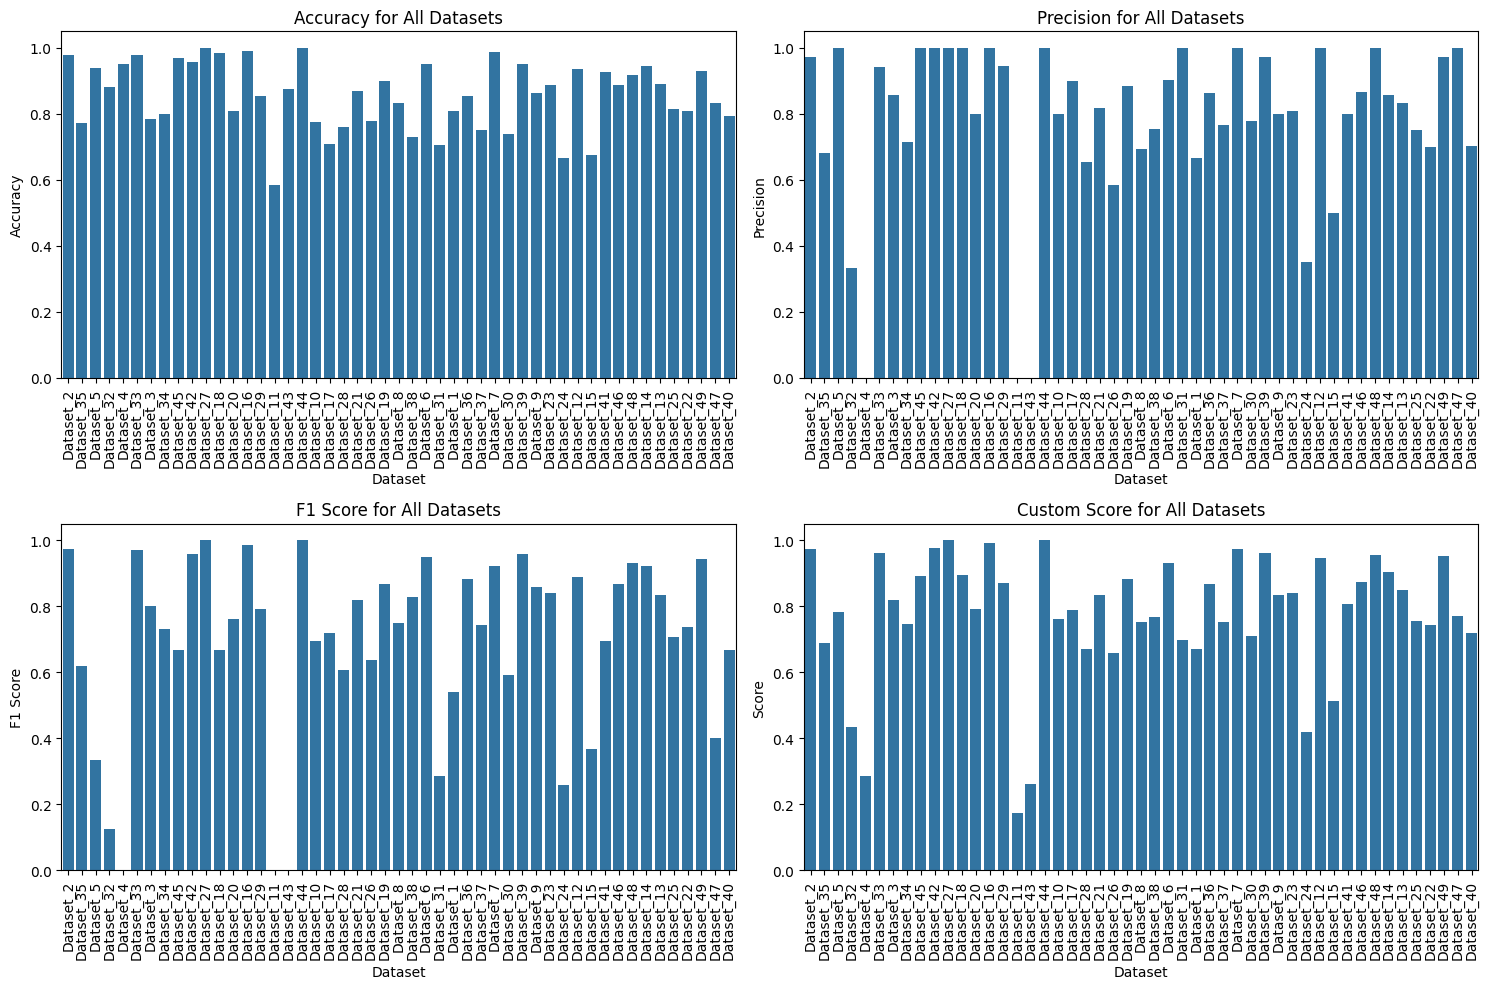

In [4]:
# Visualization Summary Chart for All Datasets
summary_df = pd.DataFrame(summary_metrics)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=summary_df, x='Dataset', y='Accuracy')
plt.title('Accuracy for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.barplot(data=summary_df, x='Dataset', y='Precision')
plt.title('Precision for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.barplot(data=summary_df, x='Dataset', y='F1 Score')
plt.title('F1 Score for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.barplot(data=summary_df, x='Dataset', y='Score')
plt.title('Custom Score for All Datasets')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
